# Overview

This project aims to analyze Flu vaccination data from 2009-2010 from the National 2009 H1N1 Flu Survey. We hope to use this data to predict the likelihood of people getting the seasonal flu vaccine in the future.

# Business Problem

Getting the flu vaccine is crucial in protecting individuals and communities from the flu virus. However, understanding the factors which influence people's decisions can be very tricky. Our job was to look at the 2009 survey and try to predict the likelihood of a person getting the vaccine. By accurately identifying the individuals likely to get the vaccine, we can tailor our efforts to promote the flu vaccine and optimize the vaccination rate. We can also identify factors which would cause individuals to not get the vaccine and develop strategies to persuade them to participate in the vaccinations.

# Table of Contents

1. Exploratory Data Analysis
2. Feature Engineering
3. Modelling
4. Feature Selection and Modelling
5. Conclusion

# 1. Exploratory Data Analysis

In [425]:
# importing relevant packages for cleaning and modeling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# For our modeling steps
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Model Evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve

%matplotlib inline

In [426]:
# Reading in data
raw_train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')


In [427]:
# Dropping features related to h1n1 and features that were missing over 10,000 observations

drop_columns = [
    'health_insurance'
    , 'employment_occupation'
    , 'employment_industry'
    , 'h1n1_concern'
    , 'h1n1_knowledge'
    , 'doctor_recc_h1n1'
    , 'opinion_h1n1_vacc_effective'
    , 'opinion_h1n1_risk'
    , 'opinion_h1n1_sick_from_vacc'
]

cleaned_train_features = raw_train_features.drop(columns=drop_columns)

In [428]:
# Combining features with the target variable "train variables" (yes/no to have taken the seasonal vaccine)
survey_data = cleaned_train_features.merge(right=train_labels, how='inner', on='respondent_id')

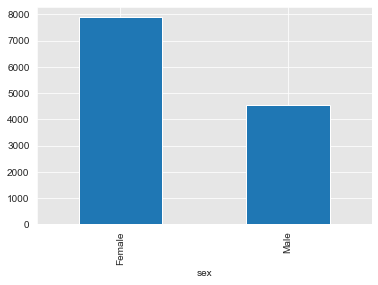

In [429]:
vaccine_by_sex = survey_data.groupby(['sex'])['seasonal_vaccine'].sum()
vaccine_by_sex.plot(kind='bar');

<AxesSubplot:xlabel='race'>

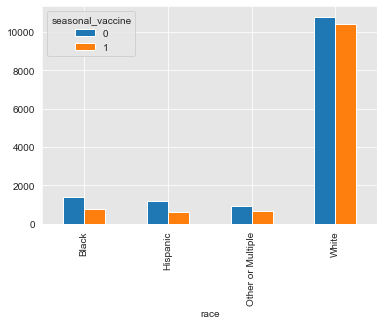

In [430]:
vaccine_by_race = survey_data.groupby(['race', 'seasonal_vaccine'])['seasonal_vaccine'].count()
vaccine_by_race.unstack().plot(kind='bar')

<AxesSubplot:xlabel='age_group'>

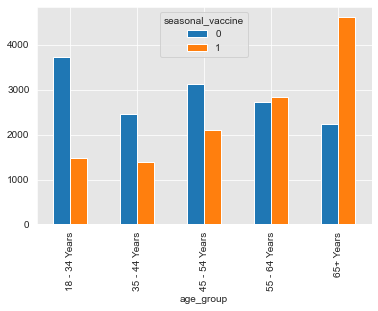

In [431]:
vaccine_by_eco_stats = survey_data.groupby(['age_group', 'seasonal_vaccine'])['seasonal_vaccine'].count()
vaccine_by_eco_stats.unstack().plot(kind='bar')

<AxesSubplot:xlabel='opinion_seas_vacc_effective'>

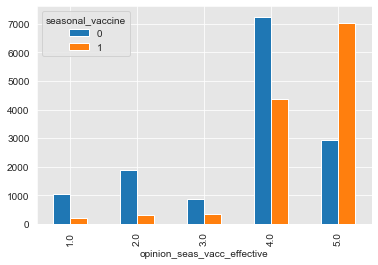

In [432]:
vaccine_by_opinion_seas_vacc_effective = survey_data.groupby(['opinion_seas_vacc_effective', 'seasonal_vaccine'])['seasonal_vaccine'].count()
vaccine_by_opinion_seas_vacc_effective.unstack().plot(kind='bar')

<AxesSubplot:xlabel='doctor_recc_seasonal'>

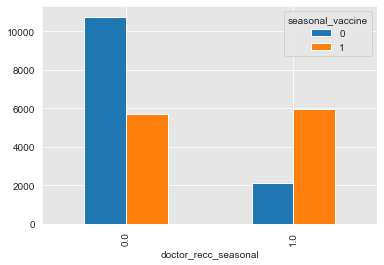

In [433]:
vaccine_by_doctor_recc_seasonal = survey_data.groupby(['doctor_recc_seasonal', 'seasonal_vaccine'])['seasonal_vaccine'].count()
vaccine_by_doctor_recc_seasonal.unstack().plot(kind='bar')

# 2. Feature Engineering

In [434]:
# Drop target variables to create a table of only features
X = survey_data.drop(columns=['seasonal_vaccine', 'h1n1_vaccine'])
# Table with only the target variable
y = survey_data['seasonal_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [435]:
# Multiclass features that require OneHotEncoder
col_encode = [
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'household_adults',
    'household_children'
]

# Binary features that don't require OneHotEncoder
col_no_encode = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face',
    'doctor_recc_seasonal',
    'chronic_med_condition',
    'child_under_6_months',
    'health_worker',

]

In [436]:
# Created a function to SimpleImpute (replace missing) values with the mode for a train data set and a test data set 
def get_imp(X, type='train'):

    # Only transform test data
    if type == 'test':
        array = imp.transform(X)
    else:
    # Fit and transform train data
        array = imp.fit_transform(X)
    # Create a dataframe with the newly imputed data
    X_imp = pd.DataFrame(array,
                         index=X.index,
                         columns=X.columns)
    
    return X_imp

# Created a function to OneHotEncode multiclass features for train and test data sets separately
def get_ohe(X, type='train'):

    # Only transform test data
    if type == 'test':
        array = ohe.transform(X)
    else:
    # Fit and transform train data
        array = ohe.fit_transform(X)
    # Create a dataframe with the newly encoded data
    X_ohe = pd.DataFrame(array,
                         index=X.index)
    X_ohe.columns = ohe.get_feature_names(X.columns)

    return X_ohe

# Impute features with its mode
imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False)

# Impute all of the values for the test and train data
X_train_imp = get_imp(X_train, type='train')
X_test_imp = get_imp(X_test, type='test')

# OneHotEncode only the multiclass features
X_train_ohe = get_ohe(X_train_imp[col_encode], type='train')
X_test_ohe = get_ohe(X_test_imp[col_encode], type='test')

# Combine the encoded multiclass features with the features that didn't need encoding into a single dataframe
X_train_imp_ohe = pd.concat([X_train_imp[col_no_encode], X_train_ohe], axis=1)
X_test_imp_ohe = pd.concat([X_test_imp[col_no_encode], X_test_ohe], axis=1)



# 3. Modelling

### Base Model: DummyClassifier

In [437]:
# Importing the DummyClassifier class to run the baseline model
from sklearn.dummy import DummyClassifier

# Instantiate a DummyClassifier object and fit on the data
baseline_model = DummyClassifier()
baseline_model.fit(X_train_imp_ohe, y_train)

# Run a prediction on the test set and get a precision score as a baseline
baseline_pred = baseline_model.predict(X_test_imp_ohe)
baseline_precision = precision_score(y_test, baseline_pred)
print(baseline_precision)
print(baseline_model.score(X_train_imp_ohe, y_train))

0.46056884292178407
0.499400898652022


c:\Users\xuqc0\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


### Decision Tree: Max Depth of 10

Precision Score: 0.7397993311036789
ROC_AUC Score: 0.8047971096531051


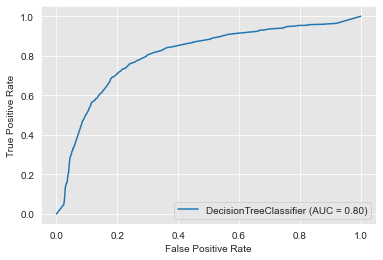

In [438]:
dt_depth_10 = DecisionTreeClassifier(random_state=1, max_depth=10)
dt_depth_10.fit(X_train_imp_ohe, y_train)

y_dt_pred = dt_depth_10.predict(X_test_imp_ohe)
dt_precision = precision_score(y_test, y_dt_pred)
print(f"Precision Score: {dt_precision}")

y_prob_dt = dt_depth_10.predict_proba(X_test_imp_ohe)
y_hat_dt = y_prob_dt[:, 1]
print(f"ROC_AUC Score: {roc_auc_score(y_test, y_hat_dt)}")

plot_roc_curve(dt_depth_10, X_test_imp_ohe, y_test);

### Model Validation Class to Simplify Process of Checking Linear Regression Model Metrics

In [439]:
class ModelValidation(metaclass=type):

    def __init__(self, X_train, X_test, y_train, y_test, model):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model

        self.y_train_pred = model.predict(X_train)
        self.y_test_pred = model.predict(X_test)

        # Residuals for train and test data
        self.y_train_resid = np.abs(y_train - self.y_train_pred)
        self.y_test_resid = np.abs(y_test - self.y_test_pred)
        
        # Accuracy Score
        self.train_accuracy = pd.Series(self.y_train_resid).value_counts(normalize=True)[0]
        self.test_accuracy = pd.Series(self.y_test_resid).value_counts(normalize=True)[0]

        # Precision Score
        self.train_precision = precision_score(y_train, self.y_train_pred)
        self.test_precision = precision_score(y_test, self.y_test_pred)
    
    # Plots a confusion matrix for the train data
    def plot_train_matrix(self):
        plot_confusion_matrix(self.model, self.X_train, self.y_train)
        plt.grid(False)

    # Plots a confusion matrix for the test data
    def plot_test_matrix(self):
        plot_confusion_matrix(self.model, self.X_test, self.y_test)
        plt.grid(False)

    # Plots a AUC curve
    def plot_auc(self):
        y_score = self.model.fit(self.X_train, self.y_train).decision_function(self.X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)

        # Seaborn's beautiful styling
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

        # print('AUC: {}'.format(auc(fpr, tpr)))
        plt.figure(figsize=(10, 8))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label=f'ROC curve {round(auc(fpr, tpr), 2)}')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    def print_report(self):
        print(classification_report(self.y_test, self.y_test_pred))



### Logistic Regression Model: Fit to All Features

In [440]:
logreg_all = LogisticRegression(random_state=1)
logreg_all = logreg_all.fit(X_train_imp_ohe, y_train)

# Instantiate ModelValidation Class for model metrics
mv_all_features = ModelValidation(X_train_imp_ohe, X_test_imp_ohe, y_train, y_test, logreg_all)

Train Accuracy: 0.7718422366450325
Train Precision: 0.7706627789615341


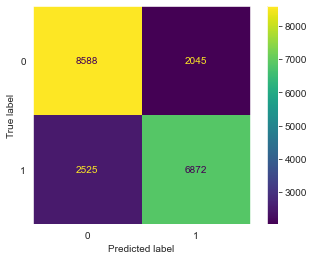

In [441]:
mv_all_features.plot_train_matrix()
print(f"Train Accuracy: {mv_all_features.train_accuracy}")
print(f"Train Precision: {mv_all_features.train_precision}")

Test Accuracy: 0.7852328890220158
Test Precision: 0.7750342935528121


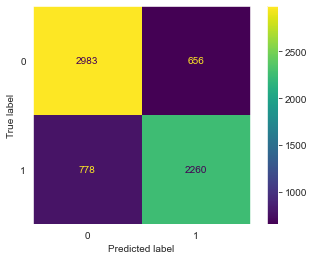

In [442]:
mv_all_features.plot_test_matrix()
print(f"Test Accuracy: {mv_all_features.test_accuracy}")
print(f"Test Precision: {mv_all_features.test_precision}")

# 4. Modelling and Feature Selection

### Logistic Regression Model: Fit to the Top 5 Most Important Features

In [443]:
importance_scores = dt_depth_10.feature_importances_

# Create a list of (feature_name, importance_score) pairs
feature_importances = [(feature, score) for feature, score in zip(X_train_imp_ohe.columns, importance_scores)]

# Sort the features based on importance score (descending order)
feature_importances.sort(key=lambda x: x[1], reverse=True)

feature_names = []
# Print the important features
for feature, score in feature_importances:
    feature_names.append(feature)

feature_names_df = pd.DataFrame(feature_importances)
feature_names_df.rename(columns = {0: 'features', 1: 'coefficients'}, inplace=True)
feature_names_df.head()

,features,coefficients
0,opinion_seas_vacc_effective_5.0,0.296641
1,doctor_recc_seasonal,0.197941
2,opinion_seas_risk_1.0,0.072736
3,age_group_65+ Years,0.055820
4,opinion_seas_risk_2.0,0.050295


In [444]:
top_5_features = feature_names[:5]

X_train_important = X_train_imp_ohe[top_5_features]
X_test_important = X_test_imp_ohe[top_5_features]

logreg_important = LogisticRegression(random_state=1)
logreg_important.fit(X_train_important, y_train)

mv_important_features = ModelValidation(X_train_important, X_test_important, y_train, y_test, logreg_important)

Train Accuracy: 0.745681477783325
Train Precision: 0.7633092644719128


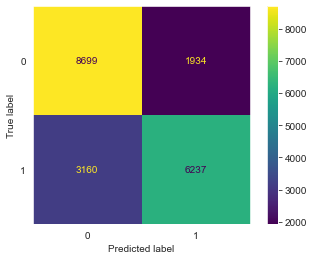

In [445]:
mv_important_features.plot_train_matrix()
print(f"Train Accuracy: {mv_important_features.train_accuracy}")
print(f"Train Precision: {mv_important_features.train_precision}")


Test Accuracy: 0.7596225849932604
Test Precision: 0.7682515911643579


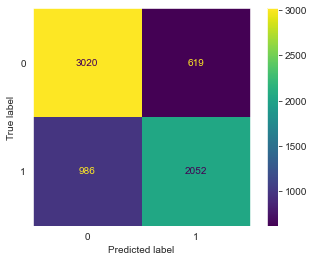

In [446]:
mv_important_features.plot_test_matrix()
print(f"Test Accuracy: {mv_important_features.test_accuracy}")
print(f"Test Precision: {mv_important_features.test_precision}")


### Logistic Regression Model: Fit to the Positive Features

In [447]:
# Return the coefficients of all features
coefficients = logreg_all.coef_[0]

# Convert the coefficients into a Pandas series
feature_coef = pd.Series(coefficients, index=X_train_imp_ohe.columns)

# Return features with only a positive coefficient
features_positive = feature_coef[feature_coef > 0]

X_train_positive_features = X_train_imp_ohe[features_positive.index]
X_test_positive_features = X_test_imp_ohe[features_positive.index]

logreg_positive = LogisticRegression(random_state=1)
logreg_positive.fit(X_train_positive_features, y_train)

mv_positive_features = ModelValidation(X_train_positive_features, X_test_positive_features, y_train, y_test, logreg_positive)


Train Accuracy: 0.7675486769845232
Train Precision: 0.7710691823899372


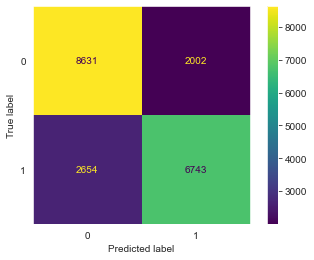

In [448]:
mv_positive_features.plot_train_matrix()
print(f"Train Accuracy: {mv_positive_features.train_accuracy}")
print(f"Train Precision: {mv_positive_features.train_precision}")

Test Accuracy: 0.7792421746293245
Test Precision: 0.7704011065006916


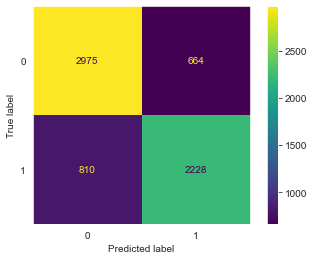

In [449]:
mv_positive_features.plot_test_matrix()
print(f"Test Accuracy: {mv_positive_features.test_accuracy}")
print(f"Test Precision: {mv_positive_features.test_precision}")

# 5. Conclusion

Based on the business problem and our data modeling, here are our recommendations to increase the number of people getting the seasonal flu vaccine:

1. Increase public awareness on effectiveness - focus on educating the public on how effective vaccines are in preventing severe illness and hospitilization.
2. Encourage doctors to recommend vaccine - emphasize to physicians the importance of discussing the vaccine with their patients
3. Target younger age groups and people of color - focus on encouraging younger people to get the vaccine. Also, reach out to leaders in minority communities to spread the word about the importance of getting vaccinated.